# Exercises Part2: 
- E01: Tune the hyperparameters of the training to beat my best validation loss of 2.2
- E02: I was not careful with the intialization of the network in this video. (1) What is the loss you'd get if the predicted probabilities at initialization were perfectly uniform? What loss do we achieve? (2) Can you tune the initialization to get a starting loss that is much more similar to (1)?
- E03: Read the Bengio et al 2003 paper ([link](https://www.youtube.com/redirect?event=video_description&redir_token=QUFFLUhqbnlHNlB5V2ZGT3lSVVljeXNMMGlUa2ktbmx3d3xBQ3Jtc0tsUGdMSU5OcWVEUHFxd0RzTVJQLVZnMzY3N3UzQXlzRE93ZjEydklDR0YwYWd6OThLNDJvNFNFM3FkajhGWGNtaU9ZVXl2VmkzR0NoYWdNUGpyeTd1RG9LN1dSRklQUHdkaEs5RWlPQWZxeW1rLUM3QQ&q=https%3A%2F%2Fwww.jmlr.org%2Fpapers%2Fvolume3%2Fbengio03a%2Fbengio03a.pdf&v=TCH_1BHY58I)), implement and try any idea from the paper. Did it work?


In [58]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt #for making figures
%matplotlib inline

In [59]:
words = open("names.txt", "r").read().splitlines()
words[:8]

['emma', 'olivia', 'ava', 'isabella', 'sophia', 'charlotte', 'mia', 'amelia']

In [60]:
len(words)


32033

In [61]:
#String to integer and integer to string mappings have been created
chars = sorted(list(set( "".join(words))))
stoi = {s:i+1 for i,s in enumerate(chars)}
stoi["."] = 0
itos = {i:s for s,i in stoi.items()}
print(itos)


{1: 'a', 2: 'b', 3: 'c', 4: 'd', 5: 'e', 6: 'f', 7: 'g', 8: 'h', 9: 'i', 10: 'j', 11: 'k', 12: 'l', 13: 'm', 14: 'n', 15: 'o', 16: 'p', 17: 'q', 18: 'r', 19: 's', 20: 't', 21: 'u', 22: 'v', 23: 'w', 24: 'x', 25: 'y', 26: 'z', 0: '.'}


In [62]:
# build the dataset

block_size = 3 #Number of characters used to predict the next one 
X, Y = [], [] #X are the inputs, Y are the labels
for w in words[:5]:
    print(w)
    context = [0] * block_size
    for ch in w + ".":
        ix = stoi[ch]
        X.append(context)
        Y.append(ix)
        print("".join(itos[i] for i in context), "--->", itos[ix])
        context = context[1:] + [ix]

X = torch.tensor(X)
Y = torch.tensor(Y)

emma
... ---> e
..e ---> m
.em ---> m
emm ---> a
mma ---> .
olivia
... ---> o
..o ---> l
.ol ---> i
oli ---> v
liv ---> i
ivi ---> a
via ---> .
ava
... ---> a
..a ---> v
.av ---> a
ava ---> .
isabella
... ---> i
..i ---> s
.is ---> a
isa ---> b
sab ---> e
abe ---> l
bel ---> l
ell ---> a
lla ---> .
sophia
... ---> s
..s ---> o
.so ---> p
sop ---> h
oph ---> i
phi ---> a
hia ---> .


<img src= "Screenshot 2024-05-14 150859.png" width= "600
">


In [63]:
X.shape, X.dtype, Y.shape, Y.dtype

(torch.Size([32, 3]), torch.int64, torch.Size([32]), torch.int64)

In [64]:
C = torch.randn((27, 2)) #We want to embed each of our 27 characters into a 2 dimensionial space
C
C[5]
C[[5,6,7]]
C[torch.tensor([5,6,7,7,7,7])] #Some random ways to access only some specific rows



tensor([[-1.2660,  1.0305],
        [-0.2507,  0.9214],
        [ 0.5152,  0.0751],
        [ 0.5152,  0.0751],
        [ 0.5152,  0.0751],
        [ 0.5152,  0.0751]])

In [65]:
emb = C[X]
emb.shape
emb


tensor([[[-1.2867,  0.8266],
         [-1.2867,  0.8266],
         [-1.2867,  0.8266]],

        [[-1.2867,  0.8266],
         [-1.2867,  0.8266],
         [-1.2660,  1.0305]],

        [[-1.2867,  0.8266],
         [-1.2660,  1.0305],
         [-0.2502, -1.0028]],

        [[-1.2660,  1.0305],
         [-0.2502, -1.0028],
         [-0.2502, -1.0028]],

        [[-0.2502, -1.0028],
         [-0.2502, -1.0028],
         [-0.3982, -0.5296]],

        [[-1.2867,  0.8266],
         [-1.2867,  0.8266],
         [-1.2867,  0.8266]],

        [[-1.2867,  0.8266],
         [-1.2867,  0.8266],
         [ 0.8780,  0.3480]],

        [[-1.2867,  0.8266],
         [ 0.8780,  0.3480],
         [-0.2977,  1.0787]],

        [[ 0.8780,  0.3480],
         [-0.2977,  1.0787],
         [-0.4937, -0.7851]],

        [[-0.2977,  1.0787],
         [-0.4937, -0.7851],
         [-0.3984, -1.5610]],

        [[-0.4937, -0.7851],
         [-0.3984, -1.5610],
         [-0.4937, -0.7851]],

        [[-0.3984, -1

<img src= "Unbenannt.png" width= "600
"> </br>
The indexes of letters from 0-26 get replaced by their embeding into a 2 Dimensional Space, with initial values generated at random from a normal distribution 

In [66]:
W1 = torch.randn((6,100)) #What does 6,100 mean? The Hidden layer in the middle has 3 inputs, which actually are our 3 characters as input
# Each of them is embedded to 2D space 2x3 = 6. So each of the 100 Neurons we created is feeded with 6 values which all get a weight we first init randomly
b1 = torch.randn(100) #Every neuron also gets a random bias 

#Neuron = (input1 * weight1 + ... + input6 * weight 6) + bias
#So we want emb @ W1 + b1 which multiplies all our examples with weights and adds a bias BUT:
#We can not multiply a shape [32,3,2] @ [100,6] we need to squash it to [32,6] @ [6,100]

torch.cat(torch.unbind(emb, 1), 1)# <=> torch.cat ([emb[:,0 , :], emb[:,1 , :], emb[:,2 , :]], 1) Which means we take a list of 0th letters, 1st letters and 2nd letters and squash them

#BUUUUUT! This is not very efficient... There is a better way

#Each tensor stores something called .storage(), this is a one dimensional representation of the tensor, because thats how it is stored in PC memory
#The method .view() manipulates how this originally one-dim tensor (or array in simpler words) is interpreted by PyTorch, so no values are copied, no additional memory is needed etc.

h = emb.view(32,6) @ W1 + b1 #Voilaaaaaa!!!

#BUUUT: We dont want to hardcode numbers...
h = emb.view(emb.shape[0], 6) @ W1 + b1
#But why is 6 still here... Shuu Shuu go away... Well we already agreed on 3 input letters and 2 Dimensional embedings so its kinda okay...

h = torch.tanh(h) #Look at the image, the layer is non linear, it is a tanh 
h

tensor([[-0.2126, -0.9898, -0.6645,  ..., -0.9998,  0.9987, -0.9992],
        [-0.3862, -0.9952, -0.6824,  ..., -0.9998,  0.9986, -0.9996],
        [ 0.8148,  0.1940, -0.5258,  ..., -0.9996,  0.8957, -0.9083],
        ...,
        [-0.5420,  0.5430,  0.0715,  ...,  0.9999, -0.9745, -0.3825],
        [ 0.9591,  0.8309, -0.0360,  ...,  0.9995,  0.1135,  0.9996],
        [ 0.7809,  0.8945, -0.9264,  ...,  0.9999,  0.9063,  0.9986]])

<img src= "Screenshot 2024-05-14 150859.png" width= "300
"><img src= "tanh.jpg" width= "300
">
<img src= "hyperbolic functions.png" width= "300
">
https://www.youtube.com/watch?v=HnHnEnkZpJA Video zum Thema hyperbolic trigonmometric functions

In [67]:
#Now we create our Output layer:
W2 = torch.randn((100, 27))
b2 = torch.randn(27)
#Again lets take a moment here. We create a layer with 27 Neurons where each neuron gets 100 inputs from the 100 neurons of the previous layer
logits = h @ W2 + b2 #What are logits? Logits are the outputs of a neural network. Usually, we plug the outputs to a softmax in order to receive a probability distribution 
counts = logits.exp()
prob =  counts / counts.sum(1, keepdim= True) #Look at the image below. This is softmax

<img src="th-1496899846.png" alt="Example Image" width="300" >
</br>
We take our "counts" and transform them into probs below </br></br>
<img src="probrow.png" alt="Example Image" width="300" >
</br> 
As you can see the probability distribution for each of the X Inputs is one

Logits have the shape [x, 100] @ [100, 27] -> [x, 27], where x is every encoded example as a row and 27 is the prob distribution for each character which sums up to one in every row

</br></br>
Now lets us look at the following:

In [68]:
enumerator = torch.arange(prob.size(dim = 0))
print(prob[enumerator, Y])
nll = -prob[enumerator, Y].log().mean() #We put all values from the table below and log them, then we take an average and then we take it by -1 to get a positive number
nll # <- Negative Log likelihood

tensor([5.5013e-05, 1.0560e-03, 1.7339e-06, 1.5768e-10, 1.0153e-08, 1.0248e-08,
        9.5688e-01, 1.6616e-11, 4.6921e-10, 1.2597e-07, 5.0286e-11, 1.9705e-08,
        1.1456e-10, 1.0334e-07, 1.4715e-12, 4.5840e-10, 6.0484e-07, 2.2798e-01,
        1.5841e-08, 1.1393e-07, 2.7705e-12, 1.1936e-16, 5.3625e-02, 1.1579e-09,
        4.6747e-08, 5.7216e-03, 8.3318e-10, 3.7254e-12, 2.5205e-07, 3.7234e-09,
        2.9696e-09, 2.6190e-05])


tensor(17.2276)

We can calculate the loss in a much easier way with a built in PyTorch function. Use in practice the expression below for better efficiency. Also backwardpass is much easier
Additionally there is one more problem. Look at the image:</br>
<img src="exp problem.png" alt="Example Image" width="300" > </br>
when some logits get extreme positve values we run out of range (inf) and get a prob nan(Not a number), we can avoid it with the built in function.
BUT how does PyTorch make it work? It turns out if you subtract a constant from all logits then we dont affect the prob distribution, so PyTorch looks for the biggest logit and substracts its value from all the logits so when end up with negative logits and 0. Now we can calculate the probs without the (inf) problem and still get the correct result

In [69]:
F.cross_entropy(logits, Y)

tensor(17.2276)

What does it mean? We print for every row of prob the current probability we give to the actual correct next character (Y if you remember are our labels)
Then as you might recall we calculate the negative log likelihood, which we will try to minimize, for our network.


In [70]:
parameters = [C, W1, b1, W2, b2]
sum(p.nelement() for p in parameters)

3481

## Summary 
we now rewrite some bits to bring it all together and create the training loop

In [71]:
for p in parameters:
    p.requires_grad = True

In [72]:
for _ in range (100):
    #forward pass
    emb = C[X]
    h = torch.tanh(emb.view(-1,6) @ W1 + b1) 
    logits = h @ W2 + b2 
    loss = F.cross_entropy(logits, Y)
    print(loss.item())
    #backward pass
    for p in parameters:
        p.grad = None
    loss.backward()
    #update
    for p in parameters:
        p.data += -0.1 * p.grad

17.227624893188477
14.045804023742676
11.812531471252441
9.7538423538208
7.972923278808594
6.546151638031006
5.383960247039795
4.424586296081543
3.775606393814087
3.386474132537842
3.0825109481811523
2.8253376483917236
2.598240852355957
2.3939528465270996
2.210319995880127
2.0472917556762695
1.9045127630233765
1.77986478805542
1.6698821783065796
1.5712823867797852
1.481765627861023
1.399857997894287
1.324498176574707
1.2548038959503174
1.1900818347930908
1.1299058198928833
1.0741232633590698
1.022742509841919
0.9757505655288696
0.9329627752304077
0.8939839005470276
0.8582892417907715
0.8253384232521057
0.794649064540863
0.7658235430717468
0.7385520935058594
0.7125958800315857
0.6877757906913757
0.663962185382843


0.6410655379295349
0.6190357208251953
0.5978596210479736
0.5775672793388367
0.5582299828529358
0.5399600863456726
0.5228988528251648
0.5071864128112793
0.49292391538619995
0.4801371097564697
0.4687640368938446
0.45867210626602173
0.4496934115886688
0.44165751338005066
0.43441060185432434
0.4278249442577362
0.42179614305496216
0.41624248027801514
0.41109776496887207
0.4063092768192291
0.40183383226394653
0.397637277841568
0.39368996024131775
0.38996705412864685
0.3864477574825287
0.383113831281662
0.37995001673698425
0.37694209814071655
0.3740779757499695
0.3713468015193939
0.36873897910118103
0.36624571681022644
0.3638594150543213
0.3615723252296448
0.3593788146972656
0.3572722375392914
0.35524776577949524
0.35330015420913696
0.3514248728752136
0.34961798787117004
0.3478752374649048
0.34619343280792236
0.3445691168308258
0.34299930930137634
0.3414810597896576
0.34001168608665466
0.3385888338088989
0.33721038699150085
0.33587390184402466
0.33457762002944946
0.3333193063735962
0.33209767

### Overfitting:
At first we only worked with the first 5 words, so our Model with over 3000 Params overfitted the data extremly, but nevertheless we didnt get loss = 0. Why? It's because already in the data set with have ambiguities like ... -> e and ... -> o </br>
This means we can not possibly fit our current model perfectly to the data already. 
### Now lets look at training the entire data set: 
Yet again we copy the code for better visibility:

In [246]:
# build the dataset but this time with all words

block_size = 3 #Number of characters used to predict the next one 
X, Y = [], [] #X are the inputs, Y are the labels
for w in words:
    context = [0] * block_size
    for ch in w + ".":
        ix = stoi[ch]
        X.append(context)
        Y.append(ix)
        context = context[1:] + [ix]

X = torch.tensor(X)
Y = torch.tensor(Y)

#Init the embedings C, the params W1, b1, W2, p2
C = torch.randn((27, 2)) 
W1 = torch.randn((6,100))
b1 = torch.randn(100) #Every neuron also gets a random bias 
W2 = torch.randn((100, 27))
b2 = torch.randn(27)
parameters = [C, W1, b1, W2, b2]
for p in parameters: 
    p.requires_grad = True

Now we encounter a performance issue, as the training takes really long... The solutions are Minibatches! We calculate the gradient based on some randomly choosen samples (batches). This leads to 2 things:
    - Our gradient is of lower quality
    - Our trainigssteps are much faster
In reality it is better to have a good estimate of the gradient ("direction we move towards to") and make more steps then have a precise value and do fewer steps

ix = torch.randint(0, X.shape[0], (32,)):
- Generates random 32 integers in a tuple from 0 to the length of X (number of examples)

emb = C[X[ix]]:
- We create a tuple of our embeded Vectors into the 2D space, but only of those 32 from the minibatch

In [245]:
for _ in range (10000):
    ix = torch.randint(0, X.shape[0], (32,)) #Generates random 32 integers in a tuple from 0 to the length of X (number of examples)

    #forward pass
    emb = C[X[ix]]
    h = torch.tanh(emb.view(-1,6) @ W1 + b1) 
    logits = h @ W2 + b2 
    loss = F.cross_entropy(logits, Y[ix])
    
    #backward pass
    for p in parameters:
        p.grad = None
    loss.backward()
    #update
    for p in parameters:
        p.data += -0.1 * p.grad
print(loss.item()) #Warning... This loss is calculated for the last minibatch not the entire set. Look below

2.5522005558013916


In [234]:
#We calculate the loss for the entire set
emb = C[X]
h = torch.tanh(emb.view(-1,6) @ W1 + b1) 
logits = h @ W2 + b2 
loss = F.cross_entropy(logits, Y)
loss.item()

2.478708028793335

### Our learning steps are currently 0.1, but it is just random... How to determine a good value?

Step 1: 
- We try a couple of values like 0.0001 0.001 0.1 1 10 etc. and see where our steps are way to big (the loss is just jumping around like a kid with ADHD)
Step 2:
- We create an exponential distribution of the learning steps where the initial steps are small and later steps are bigger
Step 3: 
- For each iteration apply a new learning rate and track the loss
Step 4:
- Plot it and choose the minimum value

In [247]:
learningRateExponent = torch.linspace(-3, 0 ,1000)
learningRateSteps = 10**learningRateExponent
learningRateI = []
lossI = []
for i in range (1000):
    ix = torch.randint(0, X.shape[0], (32,)) #Generates random 32 integers in a tuple from 0 to the length of X (number of examples)

    #forward pass
    emb = C[X[ix]]
    h = torch.tanh(emb.view(-1,6) @ W1 + b1) 
    logits = h @ W2 + b2 
    loss = F.cross_entropy(logits, Y[ix])
    
    #backward pass
    for p in parameters:
        p.grad = None
    loss.backward()
    #update
    learningRate = learningRateSteps[i]
    for p in parameters:
        p.data += -learningRate * p.grad
    #Track the learning rates
    learningRateI.append(learningRateExponent[i])
    lossI.append(loss.item())


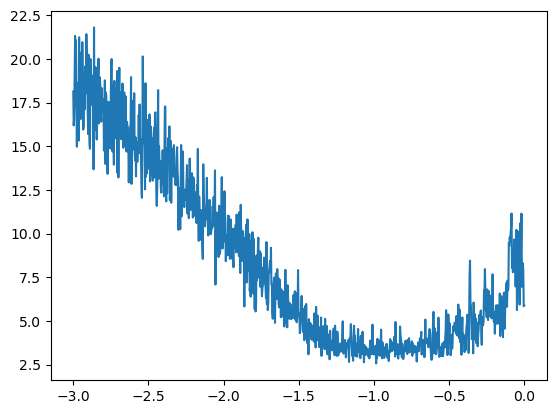

In [248]:
plt.plot(learningRateI, lossI)

As it turns out our guess that 10**-1 = 0.1 is a good learning step turned out to be good.

In practice we would also make our learning rate decay... As our loss gets smaller and starts to stagnate we decrease it to minimize the risk of overshooting

## Splitting the Data Set and Quailty evalution

In practice we split our data to e.g: 80% Training Data, 10% Dev/Validation Data, 10% Test Data
- Training Data is used for paramter optimazation
- Validation Data is used for hyperparameter optimization (number of parameters, number of hidden layers), we basically try a lot of combination to see which works best in our case
- Test is for quality evaluation (WARNING: If you test to often, then your model will more and more learn from your test data, and start overfitting the test!!!)